This is a clean reimplimentation of the steps taken in scratch work to create, validate, and test our linear model, along with visualizations for the project presentation.

In [62]:
import pandas as pd
import numpy as np

from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
nfl_data = pd.read_csv("data/full_with_ir_dead.csv")

In [4]:
nfl_data.columns

Index(['Defensive Line', 'Linebacker', 'Offensive Line', 'Quarterback',
       'Running Back', 'Secondary', 'Special Teams', 'Tight End',
       'Wide Receiver', 'Year', 'Team', 'Wins', 'Active Contracts',
       'Salary Cap', 'Dead Cap', 'Injured Reserve'],
      dtype='object')

Now let's set up a list of features we care about. We omit salary cap as it is (or nearly is) a linear combination of Dead Cap, Active Contracts, and Injured Reserve

In [13]:
X_feat = ['Defensive Line', 'Linebacker', 'Offensive Line', 'Quarterback',
       'Running Back', 'Secondary', 'Special Teams', 'Tight End',
       'Wide Receiver', 'Active Contracts', 'Dead Cap', 'Injured Reserve']

In [7]:
y_feat = ["Wins"]

Now let's run a few pairplots to take a look at our data for colinearity, then for correlation with number of wins

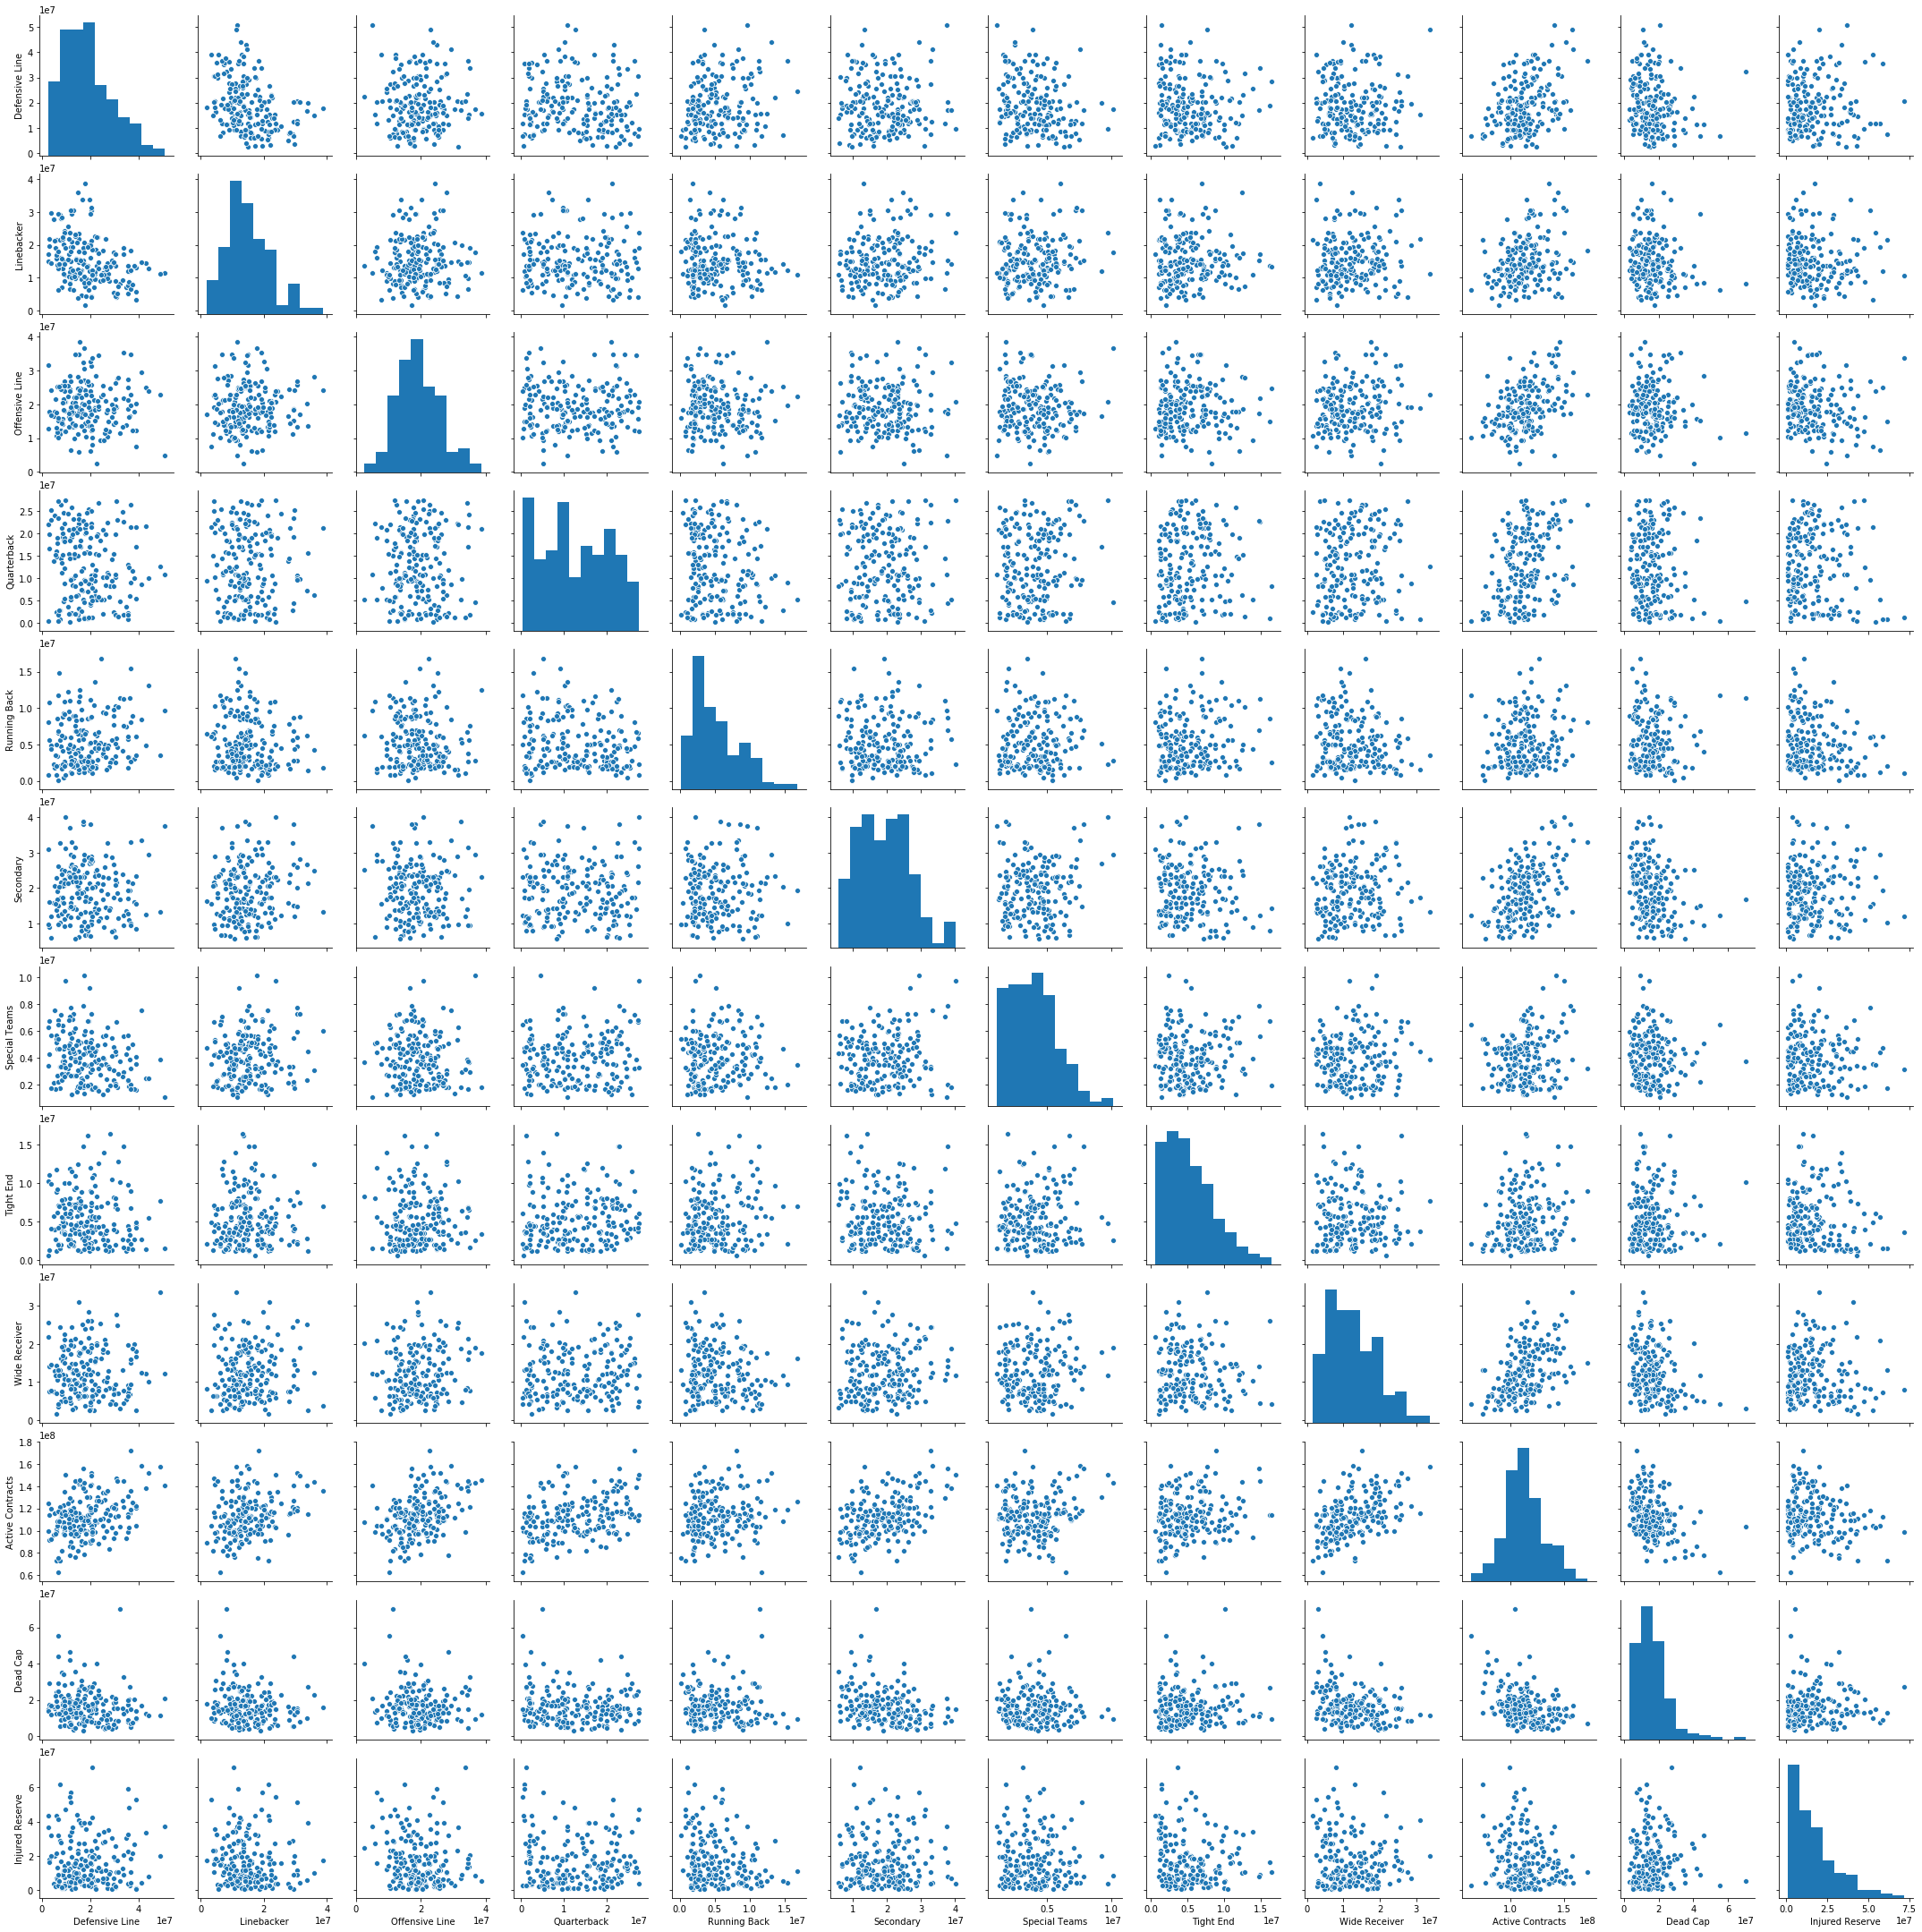

In [14]:
sns.pairplot(nfl_data[X_feat])

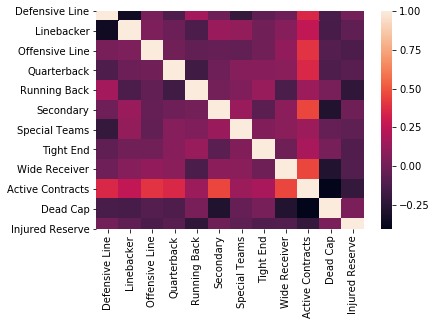

In [19]:
sns.heatmap(nfl_data[X_feat].corr())

So active contracts has some nontrivial correlation with every other contract group, as expected. This will not be an issue as we will use a LASSO regression later on which will extract out a linearly independent feature set. 

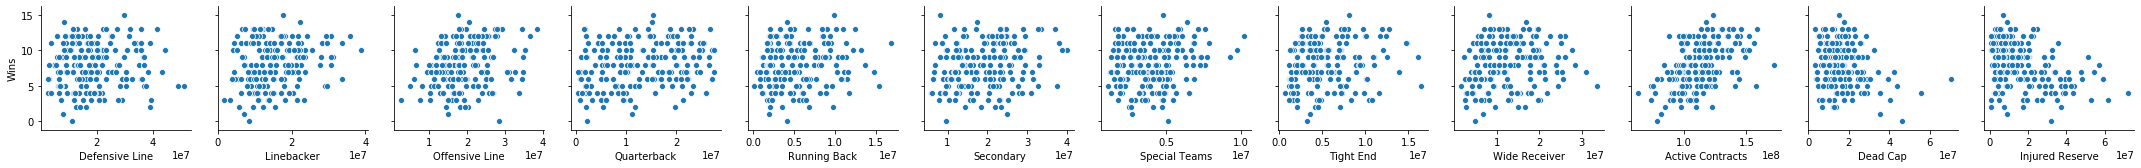

In [20]:
sns.pairplot(nfl_data,x_vars = X_feat,y_vars = y_feat)

Not the greatest of correlations, but the total active contracts and the injured reserve have a reasonable correlation with number of wins. Let's now set up a training/test split. We'll first do some tuning on alpha using our validation set. 

In [31]:
X_train_val, X_test, y_train_val, y_test = train_test_split(nfl_data[X_feat],nfl_data[y_feat],test_size=.2)

In [32]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val,test_size=.25)

In [35]:
scaler = StandardScaler()
scaler.fit(X_train)

X_scaled_train = scaler.transform(X_train)
X_scaled_val = scaler.transform(X_val)

In [39]:
alphas = 10**np.linspace(-2,2,200)

min_error = 2^31 # just initiating the variable
best_alpha = 10**-2 


for alpha in alphas:
    model = Lasso(alpha=alpha)
    model.fit(X_scaled_train,y_train)
    
    error = np.sqrt(mean_squared_error(model.predict(X_scaled_val),y_val))
    
    if error < min_error:
        min_error = error
        best_alpha = alpha


In [40]:
print(best_alpha, min_error)

0.13354515629298988 2.8045588615486


Ok so we found a value for our hyperparameter that best suits our validation data. Due to the small size of this dataset (see README for information), I decided not to further break this up into a LassoCV. Now let's train our model with all the non-test data and see how it performs on the test data. 

In [41]:
model = Lasso(alpha=0.13354515629298988)

scaler.fit(X_train_val)
X_scaled_train_val = scaler.transform(X_train_val)

model.fit(X_scaled_train_val,y_train_val)

Lasso(alpha=0.13354515629298988, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [42]:
list(zip(X_feat,model.coef_))

[('Defensive Line', -0.3692024598498751),
 ('Linebacker', 0.0),
 ('Offensive Line', 0.0263773016655318),
 ('Quarterback', 0.12669761966178578),
 ('Running Back', 0.0),
 ('Secondary', 0.0),
 ('Special Teams', 0.0358417382652944),
 ('Tight End', 0.0),
 ('Wide Receiver', -0.0),
 ('Active Contracts', 1.0824812016198695),
 ('Dead Cap', -0.43862394288292444),
 ('Injured Reserve', -0.7843722308067566)]

In [52]:
X_scaled_test = scaler.transform(X_test)

In [59]:
test_predictions = model.predict(X_scaled_test)

In [53]:
np.sqrt(mean_squared_error(test_predictions,y_test))

2.843391992619717

In [51]:
np.sqrt(mean_squared_error(model.predict(X_scaled_train_val),y_train_val))

2.4044817649765315

I'll take that RMSE difference between our training data and validation data. Furthermore, looking at the coefficients of the LASSO model we can interpret that money budgeted but not going to players is a big factor (Dead Cap / Injured Reserve), while among players the Quarterback has the highest coefficient, as one would expect from knowing the game. One interesting thing is the large negative coefficient on Defensive Line. This would require further exploration of the data to see what's happening. 

In [60]:
resid = y_test.to_numpy().ravel() - test_predictions

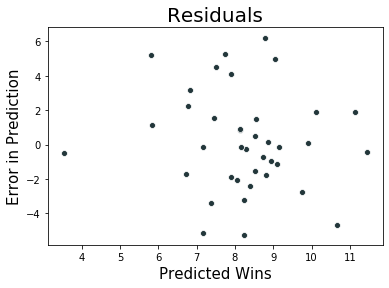

In [79]:
sns.scatterplot(test_predictions,resid, color="#23373bff")
plt.xlabel("Predicted Wins",fontsize=15)
plt.ylabel("Error in Prediction",fontsize=15)
plt.title("Residuals",fontsize=20)

plt.savefig("Presentation/residuals.svg",transparent=True)